# 5.1 Episodic Memory

In the previous chapters, learning was based on gradually adjusting weights in a neural network. However, humans have the ability to learn from a single experience without the need for repetition. One could argue that this "one-shot" learning can be achieved by a high learning rate. However, a high learning rate can lead to *catastrophic forgetting*, where the network forgets previously learned associations.

Consider for example, the [Rumelhart Semantic Network](https://princetonuniversity.github.io/NEU-PSY-502/content/502B/Computation/Statistical%20Learning%20and%20Backpropagation/notebooks/1%20Rumelhart%20Semantic%20Network.html) from the previous chapter. If we first train the network to associate various birds with flying, and then train the network with a single example of a penguin with a very high learning rate, the network will forget the previous association with birds and flying. In general, we can mitigate this problem by using interleaved training, where we mix examples from the bird-category with the penguin example. However, this doesn't reflect human learning, where we can learn from a single example without forgetting previous associations.

[McClelland et al, 1995](https://princetonuniversity.github.io/NEU-PSY-502/_static/pdf/Class%2013/McClellandEtAl1995.pdf) proposed two complemantary learning systems: A slow learning system that learns gradually from repetition (in form of weight adjustments in the Neocortex) and a fast learning system that learns from single experiences (in form of episodic memory in the hippocampus). Here, we will explore how such a episodic memory system can be modeled in PsyNeuLink.

**Installation and Setup**
> If the following code fails, you might have to restart the kernel/session and run it again. This is a known issue when installing PsyNeulink in google colab.

In [1]:
%%capture
%pip install psyneulink


import psyneulink as pnl
import numpy as np
# from torch import nn
# import torch
import matplotlib.pyplot as plt

## Episodic Memory - Python Implementation

We start with implementing a epispdic memory as python dictionary. The memory stores key-value pairs, that can be retrieved by querying the memory with a key:

In [2]:
em_dict = {
    'morning': 'breakfast',
    'afternoon': 'lunch',
    'evening': 'dinner'
}

We can retrieve memory by accessing the dictionary with a key:

In [3]:
food = em_dict['morning']
print(food)

breakfast


However, this implementation is limited in that the key has to be an exact match. For example, we can not just access "late afternoon" and get "brunch":

In [4]:
food = em_dict['late afternoon']

KeyError: 'late afternoon'

Also, to make this more general, instead of strings, we can use (one-hot encoded) vectors as keys and values. Let's build our own episodic memory that stores key-value pairs as list:

In [33]:
morning_key = np.array([1, 0, 0])  # morning
morning_value = np.array([0, 0, 1])  # breakfast

afternoon_key = np.array([0, 1, 0])  # afternoon
afternoon_value = np.array([1, 0, 0])  # lunch

evening_key = np.array([0, 0, 1])  # evening
evening_value = np.array([0, 0, 1])  # dinner

em = np.array([(morning_key, morning_value), (afternoon_key, afternoon_value), (evening_key, evening_value)])
print(em)

[[[1 0 0]
  [0 0 1]]

 [[0 1 0]
  [1 0 0]]

 [[0 0 1]
  [0 0 1]]]


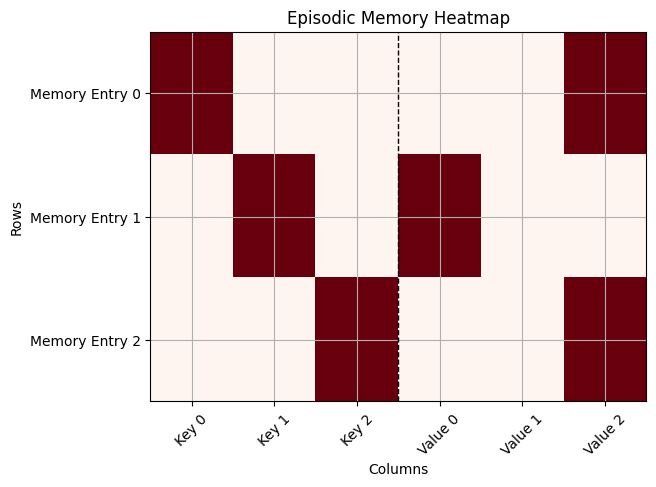

In [34]:
def plot(memory):
    """
    Plot the episodic memory as a matrix
    """
    def flatten(el):
        x = el[0]
        for i in el[1]:
            x = np.append(x, i)
        return x

    # Create a 6-row matrix (3 keys and 8 values) by padding the rows appropriately
    episodic_memory_matrix = [flatten(el) for el in memory]

    plt.imshow(episodic_memory_matrix, cmap='Reds', aspect='auto')

    labels = [f"Key {i}" for i in range(len(episodic_memory_matrix[0])//2)] + [f"Value {i}" for i in range(len(episodic_memory_matrix[0])//2)]
    plt.xticks(ticks=range(len(episodic_memory_matrix[0])),
               labels=labels, rotation=45)
    plt.yticks(ticks=range(len(episodic_memory_matrix)),
               labels=[f"Memory Entry {i}" for i in range(len(episodic_memory_matrix))])
    # Add vertical dashed line to separate groups

    plt.axvline(x=(len(labels)-1)/2, color='black', linestyle='--', linewidth=1)
    plt.grid(visible=True)
    plt.title('Episodic Memory')
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.show()


#
plot(em)



To retrieve a value, we can first search for the key that is most similar to the query key and return the corresponding value. A good measure for similarity between two vectors is the dot product.

In [37]:
# We use a query key that the model has never seen before (for exampl a interpolation between the morning and afternoon key)
query_key = np.array([.9, .1, 0])  # between morning and afternoon

matches = [np.dot(query_key, key) for key, _ in em]

# our matches are:
print('Matches: ',matches)

# and the index with the highest match is:
max_match_index = matches.index(max(matches))
print('Index where key matches the most:', max_match_index)

# matched key:
key = em[max_match_index][0]
print('Matched key:', key)

# so the value is:
value = em[max_match_index][1]
print('Matched value:', value)

Matches:  [0.9, 0.1, 0.0]
Index where key matches the most: 0
Matched key: [1 0 0]
Matched value: [0 0 1]


As expected, the most close match to "between morning and afternoon" is "morning" and we get the value "breakfast"

We can go a step further, instead of using the argmax of the matches, we can also weigh the values by their respective match. But to do that, we first need to normalize the matches (in this case we use the softmax function):

In [39]:
import math
import numpy as np

def softmax(x):
    # calculate the sum
    _sum = 0
    for el in x:
        _sum += math.exp(el)
    res = []
    for el in x:
        res.append(math.exp(el) / _sum)
    return res

query_key = [1., 1., 0.]  # half way between morning and afternoon

matches = [np.dot(query_key, key) for key, _ in em]
print('Matches:', matches)

soft_maxed_matches = softmax(matches)
print('Soft maxed Matches:', soft_maxed_matches)

weighted_values = np.sum(np.array([soft_maxed_matches[i] * np.array(value) for i, (_, value) in enumerate(em)]), axis=0)
print('Weighted Values:', weighted_values)


Matches: [1.0, 1.0, 0.0]
Soft maxed Matches: [0.4223187982515182, 0.4223187982515182, 0.15536240349696362]
Weighted Values: [0.4223188 0.        0.5776812]


Here, instead of choosing the best key (that is in memory), we calculate a weighted between the values stored in memory. The weights, in this case are similarity scores between the query key and the stored key in memory.

Exercise 1{exercise}

Instead of the above implementation of the softmax, in use cases, we use a softmax that masks values below a certain threshold. Why is this necessary? What would happen if we didn't mask values?

Hint {hint}

In our toy example we have only a few memory slots. However, in a most scenarios, we want to model a large number of episodic memory slots. In this case, the `match_weight` vector will have a large number of entries with a lot of zeros (or near zeros). Think about why that is problematic.

Solution 1{solution}

The "flattening" effect of the softmax function is dependent on the length of the vector. For example, try running the following code:

```python
res = softmax(torch.tensor([1] + [0.01] * 10))
res_2 = softmax(torch.tensor([1] + [0.01] * 100))
print(res[0])
print(res_2[0])
```


Exercise 2{exercise}

Try implementing a larger memory with more key value pairs. How does the memory retrieval hold up without masking?

 ## PsyNeuLink - EMComposition

`PsyNeuLink` provides build-in support for episodic memory through the `EMComposition`. Here, we explain the most important parameters of the `EMComposition`. It can be used to easily build more complex memory structures, and we will use it in the [next tutorial](https://princetonuniversity.github.io/NEU-PSY-502/content/502B/Computation/Episodic%20Memory/notebooks/2%20Episodic%20Generalization%20Optimization%20-%20EGO.html) in the EGO model.

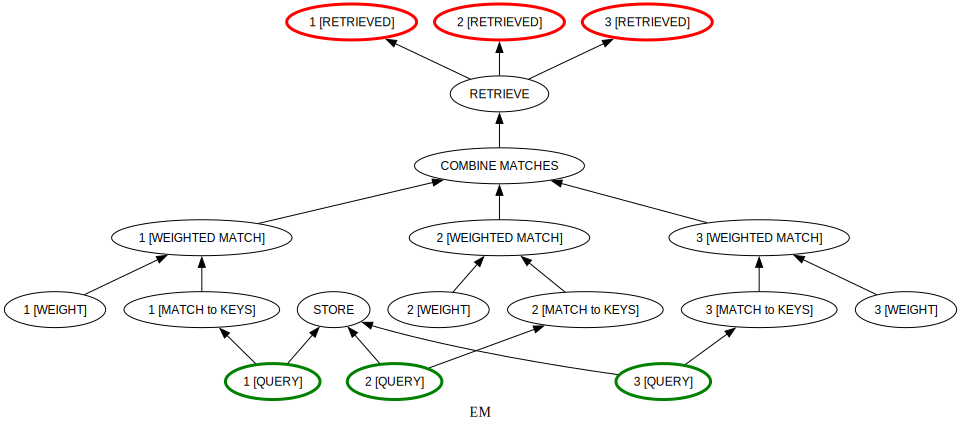

In [137]:
em = pnl.EMComposition(name='EM',  # name
                       memory_capacity=1000,  # number of key-value pairs
                       memory_template=[[0, 0], [0, 0, 0, 0], [0, 0, 0]],
                       # template for the memory. Note: Here we use 3 memory slots (instead of just a key value pair, we can store as many keys and pairs as we want.)
                       fields={'1':
                                   {pnl.FIELD_WEIGHT: .33,
                                    # weight of the key. This determines how much this "slot" influences the retrieval
                                    pnl.LEARN_FIELD_WEIGHT: False,  # The weight can be learned via backpropagation
                                    pnl.TARGET_FIELD: False
                                    # If this is a target field, the error is calculated here, and backpropagated
                                    },
                               '2': {pnl.FIELD_WEIGHT: .33,
                                     pnl.LEARN_FIELD_WEIGHT: False,
                                     pnl.TARGET_FIELD: False},
                               '3': {pnl.FIELD_WEIGHT: .33,
                                     pnl.LEARN_FIELD_WEIGHT: False,
                                     pnl.TARGET_FIELD: False},

                               },
                       memory_fill=.001,  # fill the memory with this value
                       normalize_memories=True,  # normalize the memories
                       softmax_gain=1.,  # gain of the softmax function
                       softmax_threshold=0.1,  # threshold of the softmax function
                       memory_decay=0,  # memory can be decayed over time
                       )
em.show_graph(output_fmt='jupyter')

The above figure seems complicated at first, but it follows the same principle as the torch implementation:
We look it from the bottom to the top:
- The arrows from the 1, 2, and 3 query to the "STORE" node, represent that these values are stored in memory
- All of them ara also passed through a "MATCH" node, wich calculates the similarity between the query and the stored values (just as desibed above for the keys)
- The "MATCH" nodes are then weighted and combined. (Here they are also softmaxed)
- Then the result is used to retrieve the memory by multiplying the "combined matchse" with the stored values.

Exercise 4{exercise}

In our implementation, we specified input node 1 as having 2 entries (1x2 vector), the input node 2 with 4 entries (1x4 vector), and the input node 3 with 3 entries (1x3 vector). Yet, In the explanation above, I talked about adding weighted vectors together. How can that be?

Hint {hint}
We are not adding the query vectors together but the matched weights. What is the shape of these weights?

Solution 4{solution}

The matched weights have the shape of the number of memory slots. Their entries don't represent the query vectors themselves, the `i`-th entry signifies how similar the memory in slot `i` is to the query vector.

This is why a weighted sum makes sense, we are literally weighing how similar 1, 2, and 3 is and then combining them. This way the retrieavel searches for the most combined (weighted) similarity

### Marking a Field as Value (non-query)

If we don't want specific fields to be taken into account on retrieval (for example if they are the "target" fields that the model is supposed to predict), we can set their retrieval weight to "None":

em.memory

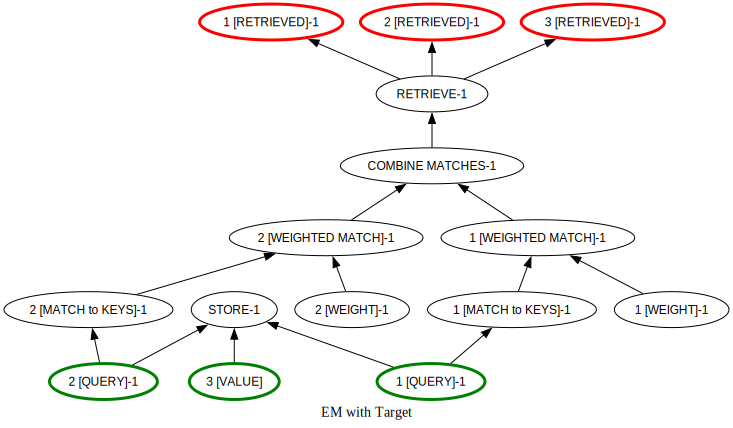

In [138]:
em = pnl.EMComposition(name='EM with Target',  # name
                       memory_capacity=1000,  # number of key-value pairs
                       memory_template=[[0, 0], [0, 0, 0, 0], [0, 0, 0]],
                       # template for the memory. Note: Here we use 3 memory slots (instead of just a key value pair, we can store as many keys and pairs as we want.)
                       fields={'1':
                                   {pnl.FIELD_WEIGHT: .5,
                                    # weight of the key. This determines how much this "slot" influences the retrieval
                                    pnl.LEARN_FIELD_WEIGHT: False,  # The weight can be learned via backpropagation
                                    pnl.TARGET_FIELD: False
                                    # If this is a target field, the error is calculated here, and backpropagated
                                    },
                               '2': {pnl.FIELD_WEIGHT: .5,
                                     pnl.LEARN_FIELD_WEIGHT: False,
                                     pnl.TARGET_FIELD: False},
                               '3': {pnl.FIELD_WEIGHT: None,
                                     pnl.LEARN_FIELD_WEIGHT: False,
                                     pnl.TARGET_FIELD: True},

                               },
                       memory_fill=.001,  # fill the memory with this value
                       normalize_memories=True,  # normalize the memories
                       softmax_gain=1.,  # gain of the softmax function
                       softmax_threshold=0.1,  # threshold of the softmax function
                       memory_decay=0,  # memory can be decayed over time
                       )
em.show_graph(output_fmt='jupyter')

As you see, this way 3 is stored (and retrieved) but is not taken into account when calculating the matched similarity (it is not "used" to retrieve from memory).